# Neural Net implementation

In this notebook, we re-implement the bi-gram model, however we model it from a neural network approach.

The neural network approach is much more flexible than the bi-gram approach and allows us to expand easily to support multi-characters as input when making our next-char prediction

### Steps:
1. Prepare the dataset as before. We split the names into pairs of two (first_char, second_char)
2. We build a NN model (a simple MLP) which takes as input x, runs it through an MLP and outputs a locally normalized output (i.e. the row using softmax (e^(w*x+b))sum(row)).
3. To calculate the loss, we want to maximize the likelihood of yi from the output vector x. The closer this is, the lower the probability.

#### Taking the softmax:
As an output to the NN we want, just like the bigram model, a set of probabilities for the next likely char.
We use the exponent function as it conveniently allows us to work in real numbers. (e^(w*x+b)). This is because when we normalize, we don't want negative probabilities (this does not exist), and negative is possible since the weights can be negative.

Given input character x, our output is now a vector [...]
x1 => (Neurons, one for each char of Alphabet)

##### Side-note: Why don't we use the sigmoid function? It gives us a probability between 0-1.
The sigmoid function (1/(1-e^(-w*x+b))) is good for classification, when multiple classes are possible in the same image (e.g. dog 0.8, wolf 0.7).
However, with next-char prediction although there are multiple next-classes, the classes are mutually exclusive. I.e. if I predict a (then it is impossible for b to also be the next char).

Sure - we could still use sigmoid and then normalize, and this would give us the probabilities right? Yes. However, sigmoid squashes the differences between possible outputs to between 0-1(which leads to saturation) whereas the exponential enhances the differences. Thus, sigmoid (after normalization) would have a smaller difference between different outputs e.g. a 0.9, b 0.8, whereas exponential would be larger e.g. a 0.8 b 0.4.

#### Calculating the loss
We want to compare the probability of x against the ground truth y.
So given x1 -> [] -> output[...] we select the corresponding index for the gt y in the output vector (and this gives us e.g. 0.02)
This is a low probability (lower than the mean, which is 1/27=0.037), thus we would want to backpropagate these to increase the weight

What should the loss function look like? 
- e.g. (1 - 0.02)? => No, this would be a high loss and it would lead to every char having a 1.0 likelihood.
- Using the log function, log(1) = 0, whereas log(0.02) = -1.6... This similarly increases the likelihood of 1-0.02 right? Why is this better?

The log approach is better because it scales, whereas the 1-.. approach does not scale. This is because when there's a incredibly wrong prediction (e.g 1^e-20) then 1- would give e.g. 1 loss whereas the log approach would give 20 loss.

Note: Taking the log of softmax (0 -> 1) leads to log(1) = 0 and log(0) -> -inf. Thus, we must take the negative log likelihood as by convention we minimize the loss.


So, our simple NN will be as follows:

Alphabet: 27 characters: a->z + '.'(beginning/end-of-sentence char)
Training sample: e.g. Amina and sample[0] = (x=a, y=m)

Training input: x=a
Fully-connected perceptron with 27 neurons (from a->z+'.')
Output vector: Softmax (e^x/sum(e^x))
Loss: -log(output[y_i])

Check:
When the probability output[y_i] is low (e.g. 0.01) for y=m, the negative log loss comes out to 2. We can take the partial derivative of this w.r.t. each weight and update (note, here we have a batch size of 1)

e.g. neuron_y_i.grad = dLoss/dneuron_y_i = d((e^w_i*x+b)/(sum(e^wx+b))))/d(w_i)

In [4]:
# # Uncomment to install imports
!pip install torch
!pip install "numpy<2"
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [5]:
#Imports
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Load the dataset
with open('../data/names.txt', 'r') as f:
    names = f.read().splitlines()

print(f"Count: {len(names)}, sample: {names[:5]}...")

Count: 32033, sample: ['emma', 'olivia', 'ava', 'isabella', 'sophia']...


In [4]:
# Write the functions to convert chars to/from integer representation
vocab = sorted(list(set("".join(names))))
print(f"Vocab: {vocab}")
print(f"Length: {len(vocab)}")

stoi = {c: i+1 for i,c in enumerate(vocab)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}

def encode(s):
    return [stoi[c] for c in s.lower()]
    
def decode(ix):
    return ''.join(itos[i] for i in ix)

#Testing
test = "hello"
print(f"String: {test}")
print(f"Encoded: {encode(test)}")
print(f"Decoded: {decode(encode(test))}")

Vocab: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Length: 26
String: hello
Encoded: [8, 5, 12, 12, 15]
Decoded: hello


In [5]:
# Prepare the data. We append start & end tokens '.', and creating sliding window of size 2 across the names.
xs, ys = [], []

# Build the dataset
for n in names:
    chs = ['.'] + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        #Create a one-hot vector of size len(vocab)
        xs.append(F.one_hot(torch.tensor(ix1), num_classes=len(vocab)+1).float())
        ys.append(ix2)

# Convert to tensors - better for operations
xs = torch.stack(xs)
ys = torch.tensor(ys)

# Split into train/val/test
n = len(xs)
train_split = int(0.8 * n)
valid_split = int(0.9 * n)

X_train, Y_train = xs[:train_split], ys[:train_split]
X_valid, Y_valid = xs[train_split:valid_split], ys[train_split:valid_split]
X_test, Y_test = xs[valid_split:], ys[valid_split:]

torch.Size([182516, 27])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([ 5, 13, 13,  1,  0])


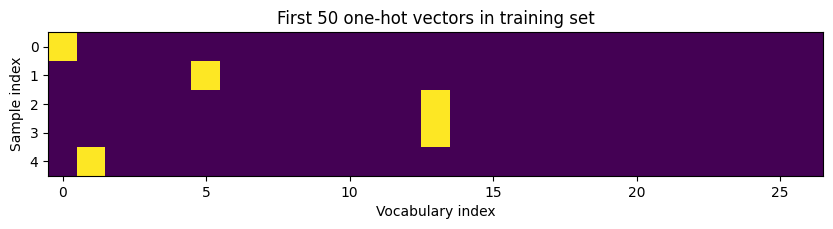

In [6]:
print(X_train.shape)
print(X_train[:5])
print(Y_train[:5])

plt.figure(figsize=(10,5))
plt.imshow(X_train[:5])
plt.title('First 50 one-hot vectors in training set')
plt.xlabel('Vocabulary index')
plt.ylabel('Sample index')
plt.show()

In [7]:
# Our data is now prepared.
# We now want to pass through our params through an MLP of size vocab_size.
# In this simple NN, we only have the output layer, of size (1,len(vocab)=26)
import numpy as np

#TODO: How does karpathy effectively implement the learning rate
batch_size = 32
lr = 1e-1

#TODO: How to correctly initialize and sample
params = torch.randn((len(vocab)+1, len(vocab)+1), dtype=torch.float32, requires_grad=True)
losses = []

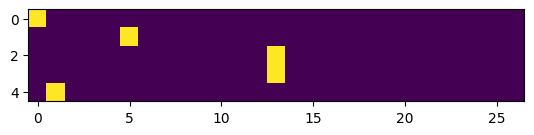

In [8]:
batch = X_train[:5]
# Each batch is a one-hot encoded vector
plt.imshow(batch)

In [9]:
W = torch.randn((27,27))

batch.shape #5, 27
W.shape #27,27

(batch @ W).shape #5,27 * 27, 27 = 5,27 (for each vector of the batch, what is the next_char conditional probability distribution?)

ix = torch.randint(0, len(X_train), (batch_size, ))
ix
batch = X_train[ix]
batch.shape

(batch @ W).shape

torch.Size([32, 27])

In [16]:
for i in range(10000):
    loss = 0

    # Randomly sample a batch of size batch_lenth from the training
    ix = torch.randint(0, len(X_train), (batch_size, ))
    batch = X_train[ix]
    y = Y_train[ix]

    # Forward pass
    logits = batch @ params # matrix multiply by the params
    counts = logits.exp() #exponentiate to get positive numbers (as we don't want negative probs)
    probs = counts / counts.sum(1, keepdim=True) #We sum across dim=1 shape: (27,1) rather than dim=1 (1, 27) because we want avg across rows
    
    # Loss calculation
    loss += -probs[torch.arange(batch_size), y].log().mean() + 0.01 * (params**2).mean() #We add a regularization
    losses.append(loss.data)

    loss.backward()
    
    #Optimizer step
    params.data += -lr * params.grad #TODO: Practice determining the correct LR using karpathy's technique
    params.grad = None #Set gradient to 0, it is more efficient than params.grad=0 (PyTorch optimizes behind-the-hood)

    if i % 100 == 0:
        print(f"iter: {i}, loss: {loss}")

print(f"train loss: {loss}")

iter: 0, loss: 2.6272096633911133
iter: 100, loss: 2.488914966583252
iter: 200, loss: 2.555111885070801
iter: 300, loss: 2.141125202178955
iter: 400, loss: 2.591427803039551
iter: 500, loss: 2.7488439083099365
iter: 600, loss: 2.344137668609619
iter: 700, loss: 2.4952564239501953
iter: 800, loss: 2.081071376800537
iter: 900, loss: 2.4654064178466797
iter: 1000, loss: 2.570646286010742
iter: 1100, loss: 2.92041277885437
iter: 1200, loss: 2.429896593093872
iter: 1300, loss: 3.0396132469177246
iter: 1400, loss: 2.4168598651885986
iter: 1500, loss: 2.233934164047241
iter: 1600, loss: 2.524751901626587
iter: 1700, loss: 2.460667848587036
iter: 1800, loss: 2.3626933097839355
iter: 1900, loss: 2.2759053707122803
iter: 2000, loss: 2.5525712966918945
iter: 2100, loss: 2.2858357429504395
iter: 2200, loss: 2.716334104537964
iter: 2300, loss: 2.4021549224853516
iter: 2400, loss: 2.3184657096862793
iter: 2500, loss: 2.7645134925842285
iter: 2600, loss: 2.641517400741577
iter: 2700, loss: 2.18953919

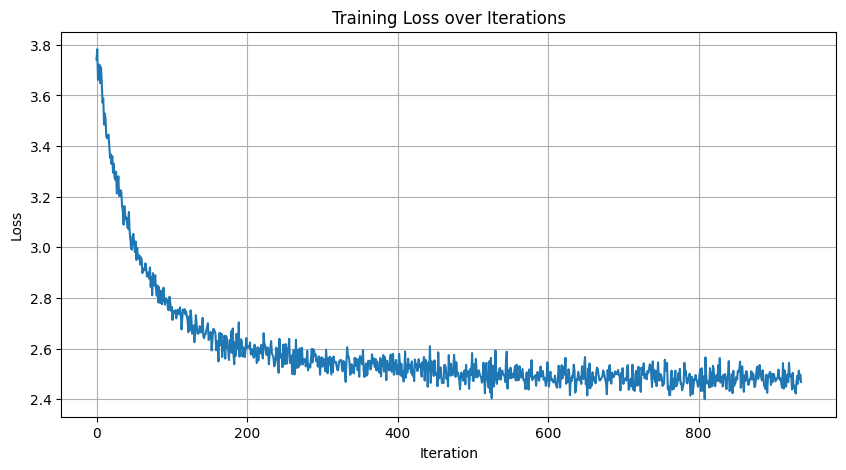

In [17]:
#We average the loss per batch_size iteration (as there is a lot of instability within batch losses) to have a more stable view of the loss
avg_losses = []

avg_loss = 0

for i, loss in enumerate(losses):
    if i % batch_size == 0 and i != 0:
        avg_losses.append(avg_loss/batch_size)
        avg_loss = 0
    
    avg_loss += loss

plt.figure(figsize=(10, 5))
plt.plot(avg_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.grid(True)
plt.show()


In [24]:
# Sampling: We encode the start_token as a vector, and continually sample from the NN till we get an end_token
names = []

for _ in range(10):
    curr_index = 0
    result = ""

    while True:
        with torch.no_grad():
            start = F.one_hot(torch.tensor(curr_index), num_classes=len(stoi)).float()
            logits = start @ params
            counts = logits.exp()
            p = counts / counts.sum()
            
            curr_index = torch.multinomial(p, num_samples=1, replacement=True).item()
            result += itos[curr_index]

            if curr_index == 0:
                break

    result
    names.append(result)

for name in names:
    print(name)

'avin.'